# PathMNIST: Image Classification

In [248]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

import time


## 1. Data loading, exploration, and preprocessing


In [251]:
# Loading the train and test datasets as numpy arrays
X_train = np.load('Data/X_train.npy')
X_test = np.load('Data/X_test.npy')

y_train = np.load('Data/y_train.npy')
y_test = np.load('Data/y_test.npy')

In [253]:
# Dictionary for mapping the class labels (0-8) to their tissue types
#Based on the Path MNIST paper containing dataset
class_labels = {
    0: "Adipose (fat)",
    1: "Background",
    2: "Debris",
    3: "Lymphocytes",
    4: "Mucus",
    5: "Smooth muscle",
    6: "Normal mucosa",
    7: "Stroma",
    8: "Tumor epithelium"
}

The dataset consists of 9 tissue types; consisting of healthy tissues types like lymphocytes, adipose and abnormal tissue types like tumo epithelium

In [256]:
# Examining the dataset structure

# X train and X test would have shape (N,28,28,3) Where : 
# N: No. of images
# 28 X 28 : Pixels
# 3 : RGB Color channel

print("Shape of X_train:", X_train.shape) 
print("Shape of X_test :", X_test.shape)

# Y train and test would have shape (N,)
#Contains the class labels
print("Shape of y_train :", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nNumber of training samples:", len(X_train))
print("Number of test samples:", len(X_test))

Shape of X_train: (32000, 28, 28, 3)
Shape of X_test : (8000, 28, 28, 3)
Shape of y_train : (32000,)
Shape of y_test: (8000,)

Number of training samples: 32000
Number of test samples: 8000


In [258]:
# Exploring the unique class labels
print("Number of unique classes:", len(np.unique(y_train)))
print("Unique class labels:", np.unique(y_train))

Number of unique classes: 9
Unique class labels: [0 1 2 3 4 5 6 7 8]


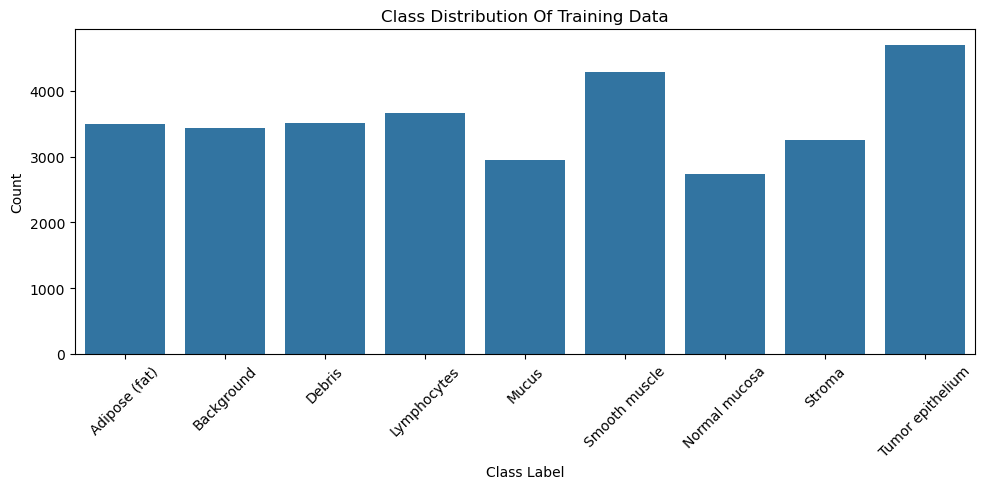

In [260]:
# Visualising the class distribution
# This helps to observe any class imbalance
# Also helps to understand the real world class distribution required for medical datasets like Path MNIST

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution Of Training Data")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(ticks=range(9), labels=class_labels.values(), rotation=45)
plt.tight_layout()
plt.show()


There was a slight imbalance, with some classes i.e. class 8 and class 5 are more represented than others i.e. class 6. 
This could skew model learning in unregularized models or when accuracy of the model is the sole evaluation criteria.

### Examples of preprocessed data

In [271]:
# Normalizing the pixel values to the range [0, 1], to ensure similar scale
# Helps in improving convergence and training stability

X_norm_train = X_train.astype('float32') / 255.0
X_norm_test = X_test.astype('float32') / 255.0


In [273]:
# checking if the labels are one-hot encoded or not 
# making sure they are in flat format
if y_train.ndim > 1:
    y_flat = np.argmax(y_train, axis=1)
else:
    y_flat = y_train

unique_class_labels = np.unique(y_flat)
print("unique classes" , unique_class_labels)

unique classes [0 1 2 3 4 5 6 7 8]


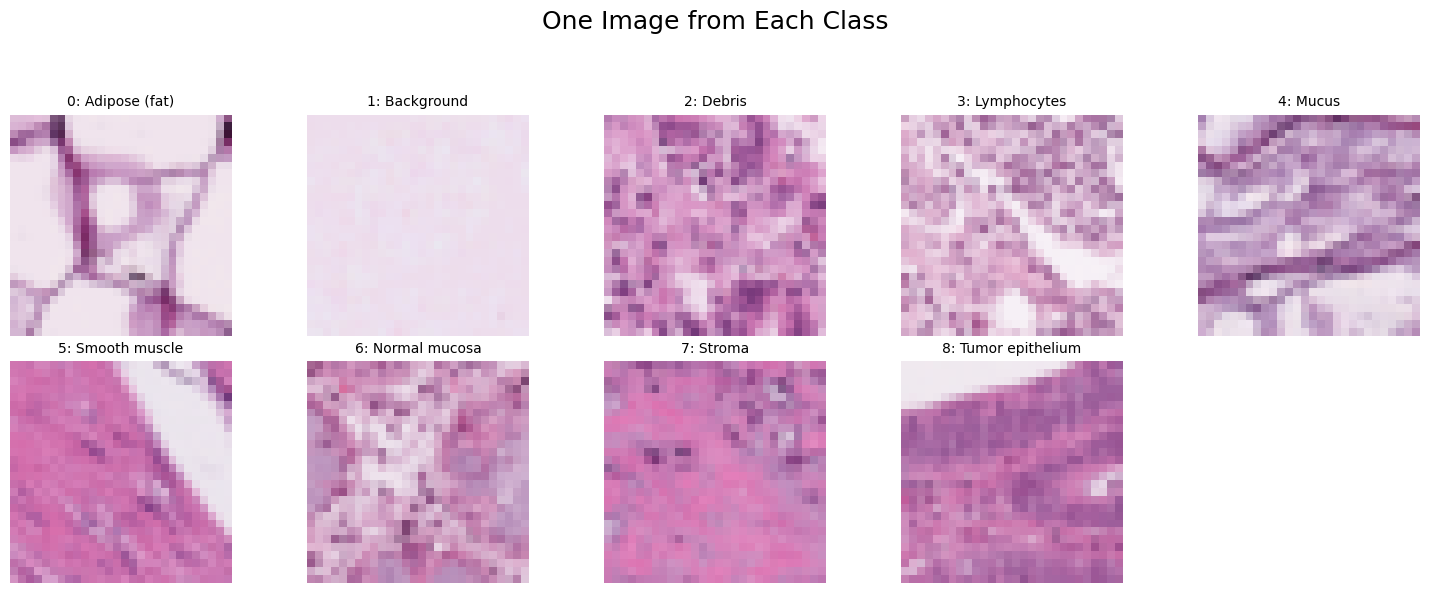

In [275]:
# Creating a subplot with 2 x 5 grid to visualise the 9 classes 
plt.figure(figsize=(15, 6))
i = 2
j=5

for idx, cls in enumerate(unique_classes):
    sample_idx = np.where(y_flat == cls)[0][0]
    plt.subplot(i, j, idx+1)
    plt.imshow(X_train[sample_idx].astype('uint8'))
    plt.title(f"{cls}: {class_labels[cls]}", fontsize=10)
    plt.axis('off')
plt.suptitle("One Image from Each Class", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for main title
plt.show()


Some classes like 0,1 had visually distinct appearance whereas 6,7,8 was visually similar. Some images were noisy, blurred that could skew the model. 

### 2. Algorithm design and setup

In [279]:
# Flatten images to 1D for ML algorithms like k-NN, Random forest and MLP
X_train_flat = X_norm_train.reshape(X_norm_train.shape[0], -1)
X_test_flat = X_norm_test.reshape(X_norm_test.shape[0], -1)

print("Flattened training shape:", X_train_flat.shape)
print("Flattened test shape:", X_test_flat.shape)


Flattened training shape: (32000, 2352)
Flattened test shape: (8000, 2352)


#### Initial Experiment: k-Nearest Neighbors (k-NN) [Not Used in Final Models]
This model was explored during early experiment phase but due to its poor performance , it was not included further in the study

In [282]:
# Developing knn model with k=3
knn_model = KNeighborsClassifier(n_neighbors=3)

# Fitting the model on the flattened data
knn_model.fit(X_train_flat, y_train)

KNeighborsClassifier(n_neighbors=3)

In [284]:
# Predicting the class label values
y_pred_knn = knn_model.predict(X_test_flat)

# Calculating the accuracy for knn
accuracy_knn = accuracy_score(y_test, y_pred_knn)

In [285]:
print(f"Test Accuracy k-NN (k=3): {accuracy_knn:.4f}")

Test Accuracy k-NN (k=3): 0.2956


Due to the poor accuracy obtained, we have decided that we would not be including KNN in our further model development.  

The remainder of the report focuses on more scalable models: **Random Forest, MLP, and CNN**.


## Random Forest

In [289]:

# Initializing the random forest model with 100 decision trees (n_estimators)
# Setting random state to ensure same results
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the flattened training data
rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [290]:
# Generate prediction labels for test set
y_pred_rf = rf_model.predict(X_test_flat)

# Calculate accuracy by comparison with true labels
accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [291]:
print(f"Test Accuracy - Random Forest: {accuracy_rf:.4f}")

Test Accuracy - Random Forest: 0.6448


The model achieved a prediction accuracy of 64.48% on the data, which shows that it was able to generalise well despite the lack of spatial structures in the input. 

This shows the model works well with tabular data, even without image structure. 

### Fully Connected Neural Network (Multilayer Perceptron - MLP)

In [296]:
# converting integer class labels (0-8) to one hot encoded vectors
y_train_cat = to_categorical(y_train, num_classes=9)
y_test_cat = to_categorical(y_test, num_classes=9)

print("Shape of y training data", y_train_cat.shape)
print("Shape of y testing data:", y_test_cat.shape)


Shape of y training data (32000, 9)
Shape of y testing data: (8000, 9)


In [297]:
# Building a simple MLP model
# Input is of the shape 28 x 28 x 3  flattened RGB 
#128 Neurons and ReLu activation in the dense layer
# ReLu function : If the signal is strong, pass it forward; or if the signal is weak, ignore it.”
# Output layer has 9 neurons with 9 classes
# Dropout layer randomly ignores 30% of the data # this prevents any particular data from dominating
mlp_model = Sequential([ Dense(128, activation='relu', input_shape=(2352,)), 
    Dropout(0.3), Dense(9, activation='softmax')])

mlp_model.summary()


C:\Users\mridu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,345 (1.15 MB)

 Trainable params: 302,345 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [298]:
# Complining the MLP model
#Adam optimiser is suitable for most problems due to its adaptability
# 'categorical_crossentropy' loss function is suitable for multi-class classification problem

mlp_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Using the flattened image data to train the MLP model 
# Using one ehot encoded labels 
# Training model for 10 full passes i.e 10 epochs
# Updating the weights after every 128 samples i.e. batch size =128
#
history_mlp = mlp_model.fit( X_train_flat, y_train_cat,
    epochs=10,batch_size=128, validation_split=0.2,verbose=1 )


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1343 - loss: 2.3087 - val_accuracy: 0.2500 - val_loss: 2.1056
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1988 - loss: 2.1058 - val_accuracy: 0.2678 - val_loss: 2.0503
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1989 - loss: 2.0739 - val_accuracy: 0.2937 - val_loss: 2.0132
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2012 - loss: 2.0617 - val_accuracy: 0.2841 - val_loss: 1.9801
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2099 - loss: 2.0434 - val_accuracy: 0.2858 - val_loss: 1.9624
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2061 - loss: 2.0411 - val_accuracy: 0.2917 - val_loss: 1.9645
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2125 - loss: 2.0321 - val_accuracy: 0.3020 - val_loss: 1.9407
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2106 - loss: 2.0301 - val_accuracy: 0.

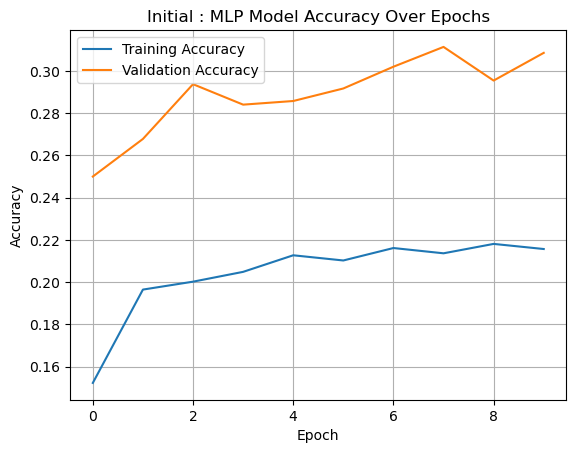

In [299]:
# # Plotting learning curve for MLP
# shows how model is learning with passing epochs
# Large distance between the training and validation line shows the model is not generalising well
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title("Initial : MLP Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


The above curve shows that the learning behaviour stagnates across epochs as it remained flat, potraying underfitting

In [339]:
# Evaluate accuracy of the untrained MLP
test_loss_mlp, test_acc_mlp = mlp_model.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"Test Accuracy of Untuned MLP: {test_acc_mlp:.4f}")

Test Accuracy of Untuned MLP: 0.3120


The test accuracy of the MLP model is : 31.20% ( Untuned). This low performance of the MLP model is likely due to lack of spatial intelligence, tiny images and no convolutional layers. 

### Convolutional neural network

In [301]:
# converting integer class labels (0-8) to one hot encoded vectors
y_train_cat = to_categorical(y_train, num_classes=9)
y_test_cat = to_categorical(y_test, num_classes=9)

# Printing the shape for verification:
print("Shape of y_train:", y_train_cat.shape)
print("Shape of y_test:", y_test_cat.shape)

Shape of y_train: (32000, 9)
Shape of y_test: (8000, 9)


In [302]:
#  Reshaping the data for CNN model
# Expected format : # (number of samples, image height, image width, number of channels)
# -1 : enables NumPy to infer the number of samples itself

X_train_cnn = X_norm_train.reshape(-1, 28, 28, 3)
X_test_cnn = X_norm_test.reshape(-1, 28, 28, 3)

print("Shape of X_train for CNN:", X_train_cnn.shape)
print("Shape of X_test for CNN:", X_test_cnn.shape)

Shape of X_train for CNN: (32000, 28, 28, 3)
Shape of X_test for CNN: (8000, 28, 28, 3)


In [303]:
cnn_model = Sequential()

# Layer 1: Convolution layer with the ReLu activation function
# 32 filters of size 3 x 3 each
# 28 x 28 images with 3 rgb channels
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))

# Layer 2: Max Pooling 
# Downsampling by taking the max value in each 2 x 2 window
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

C:\Users\mridu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [304]:
# Flatten the 2D feature maps into a 1D vector
# Preparing the data to the right format for inout in the dense layers
cnn_model.add(Flatten())

# Dense layer 
# acts as decision making with 128 neurons
cnn_model.add(Dense(128, activation='relu'))

# Dropout Layer
# Randomly ignores 50% of data during training to help model generalise better to unseen data
cnn_model.add(Dropout(0.5))

# Output layer contains 9 neurons each for 1 class label (0-8)
cnn_model.add(Dense(9, activation='softmax'))


In [305]:
# Complining the CNN model
# Adam optimiser is suitable for most problems due to its adaptability
#'categorical_crossentropy' loss function is suitable for multi-class classification problem

cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [306]:
# Using the flattened image data to train the MLP model 
# Using one ehot encoded labels 
# Training model for 10 full passes i.e 10 epochs
# Updating the weights after every 128 samples i.e. batch size =128
# using 20% of data for validation
history_cnn = cnn_model.fit( X_train_cnn, y_train_cat,
    epochs=10,batch_size=128,validation_split=0.2,verbose=1)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2646 - loss: 1.9440 - val_accuracy: 0.4995 - val_loss: 1.4491
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4320 - loss: 1.5179 - val_accuracy: 0.5323 - val_loss: 1.2716
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4783 - loss: 1.3858 - val_accuracy: 0.5745 - val_loss: 1.1596
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5173 - loss: 1.2831 - val_accuracy: 0.6142 - val_loss: 1.0676
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5490 - loss: 1.1933 - val_accuracy: 0.5797 - val_loss: 1.0912
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5609 - loss: 1.1777 - val_accuracy: 0.6136 - val_loss: 1.0350
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5611 - loss: 1.1592 - val_accuracy: 0.6497 - val_loss: 0.9695
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5940 - loss: 1.0863 - val_accuracy: 0.

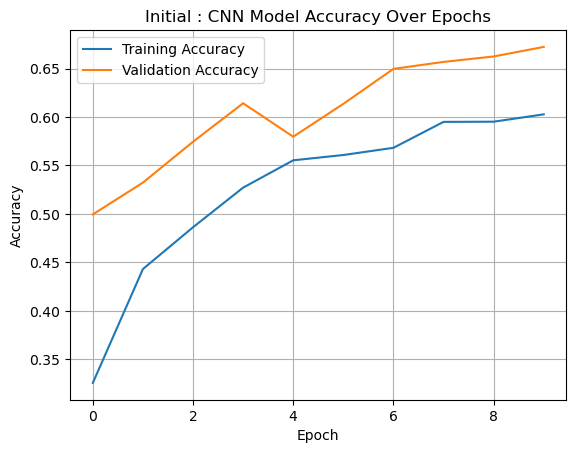

In [307]:
import matplotlib.pyplot as plt

# Plotting learning curve for CNN
# shows how model is learning with passing epochs
# small distance between the training and validation line shows the model is generalising well
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("Initial : CNN Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [308]:
# Evaluate the CNN model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy of CNN: {test_accuracy:.4f}")


Test Accuracy of CNN: 0.6745


The basic model for CNN attained 62.77% test accuracy, owing to the advantage of interpreting spatial patterns.

## 3. Hyperparameter tuning

### Random Forest

In [309]:
# Define a parameter grid for tuning of Random Forest 
# n_estimators: No of decision trees
# max_depth: This parameter controls the growth of trees; None implies nodes are expanded till last
# max_features : number of features to be selected while splitting node; 'sqrt' is default for classification, 'log2' is a common preference

param_grid_rf = {'n_estimators': [50, 100, 150],'max_depth': [None, 10, 20],'max_features': ['sqrt', 'log2']}
    

In [310]:
# Defining the base model with a fixed random state for reproducing same result
rf = RandomForestClassifier(random_state=42)

# Implementing Grid Search with 3-fold cross-validation for finding the combination of parameters with best accuracy
grid_search_rf = GridSearchCV( 
    estimator=rf, # model for tuning
    param_grid=param_grid_rf, # grid defined above
    cv=3, #3 fold cross val 
    scoring='accuracy', # evaluation metric
    verbose=1, 
    n_jobs=-1  # use all available cpu 
)


In [311]:
# Fit the model on above grid search
grid_search_rf.fit(X_train_flat, y_train)

print("Best Parameters for Random fores:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", grid_search_rf.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters for Random fores: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
Best Cross-Validation Accuracy for Random Forest: 0.6434375852437529


In [312]:
# Retraining the Random foreest model with the best hyper parameters obtained above
# Initializing the values of the best parameters
best_rf = RandomForestClassifier( 
    max_depth=None, # None means tree grows till end without any restriction
    max_features='sqrt', # use square root of total features
    n_estimators=150, #No of decision trees in the forest
    random_state=42 #Setting this for reproducibility
)

# Training the model on the best hyperparameters
best_rf.fit(X_train_flat, y_train)

# Predicting labels
y_pred_rf_best = best_rf.predict(X_test_flat)

In [313]:
#Calculating Accuracy of the model developed from best hyperparameters
test_accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)

print(f"Test Accuracy of Tuned Random Forest: {test_accuracy_rf_best:.4f}")


Test Accuracy of Tuned Random Forest: 0.6551


### Fully connected neural network (Multilayer Perceptron - MLP)

In [360]:
# Define a KERAS compatible tunable model for MLP 

def build_mlp_model(units=128, dropout=0.3):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    #Simple architecture
    model = Sequential()
    #Adding the Input layer and 1 Dense layer with the ReLu activation function
    model.add(Dense(units, activation='relu', input_shape=(2352,)))
    #Adding the dropout layer to prevent overfitting of data
    model.add(Dropout(dropout))
    #Adding the output later, for 9 class labels
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [362]:
# wrapping MLP model into scikit learn compatible classifier
mlp_clf = KerasClassifier( model=build_mlp_model,verbose=0)

In [364]:
# Defining the hyperparameter grid
param_grid_mlp = {
    'model__units': [64, 128],          # Controls the number of neurons in the hidden layer
    'model__dropout': [0.3, 0.5],       # Dropout rate (Ignores a subset of data that helps prevent overfitting)
    'batch_size': [64, 128],            # Controls the number of samples per training batch
    'epochs': [10, 15]                  # Controls the number of iterations of training data
}

In [366]:
# Defining the setup for Grid Search CV 3 fold validation
#  estimator=mlp_clf : MLP model wrapped in KerasClassifier
# Evaluation metric: accuracy
# n_jobs = -1 to use all availavle CPU Cores
grid_search_mlp = GridSearchCV(estimator=mlp_clf, param_grid=param_grid_mlp,scoring='accuracy',   
    cv=3, verbose=1, n_jobs=-1 )

# Running the grid search
grid_search_mlp.fit(X_train_flat, y_train_cat)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\mridu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GridSearchCV(cv=3,
             estimator=KerasClassifier(model=<function build_mlp_model at 0x0000026296E60E00>, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [64, 128], 'epochs': [10, 15],
                         'model__dropout': [0.3, 0.5],
                         'model__units': [64, 128]},
             scoring='accuracy', verbose=1)

In [368]:
# print the best parameters and score
print("Best Parameters (MLP):", grid_search_mlp.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_mlp.best_score_)

Best Parameters (MLP): {'batch_size': 64, 'epochs': 15, 'model__dropout': 0.3, 'model__units': 128}
Best Cross-Validation Accuracy: 0.29333920941540986


In [370]:
# Rebuild the MLP model with the best hyperarameters obtained above 
best_mlp_model = build_mlp_model(units=128, dropout=0.3)

# Train the model with the values obtained
# Using the flattened image data to train the MLP model 
# Using one ehot encoded labels 
# Training model for 15 full passes i.e 15 epochs
# Updating the weights after every 64 samples i.e. batch size =64
history_best_mlp = best_mlp_model.fit( X_train_flat, y_train_cat,
    epochs=15,batch_size=64,verbose=1, validation_split=0.2)


Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1585 - loss: 2.2141 - val_accuracy: 0.2345 - val_loss: 1.9681
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2169 - loss: 1.9864 - val_accuracy: 0.2494 - val_loss: 1.8900
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2323 - loss: 1.9547 - val_accuracy: 0.2958 - val_loss: 1.8661
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2313 - loss: 1.9353 - val_accuracy: 0.2798 - val_loss: 1.8215
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2338 - loss: 1.9316 - val_accuracy: 0.3055 - val_loss: 1.8074
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2424 - loss: 1.9239 - val_accuracy: 0.3189 - val_loss: 1.7914
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2517 - loss: 1.9157 - val_accuracy: 0.3305 - val_loss: 1.8286
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - loss: 1.9174 - val_accuracy: 0.

In [372]:
# Evaluate on test set
test_loss_mlp, test_acc_mlp = best_mlp_model.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"Test Accuracy of Tuned MLP: {test_acc_mlp:.4f}")

Test Accuracy of Tuned MLP: 0.3364


### Convolutional neural network

In [113]:
# Defining the CNN model builder function for GridSearchCV
#Input shape: RGB Images of (28,28,3)
#Conv2D layer (32 filters, 3×3 kernel): This applies the 32 filters of size 3 x 3, which is used to detect edges, fine-grained textures and blobs.
#ReLU activation:   Adds non-linearity to help learn abstract patterns
#MaxPooling2D (2×2): This shrinks the feature map to only include the most important features
#Conv2D layer (64 filters, 3×3 kernel): It applies 64 filters to learn more abstract patterns
#ReLU activation:   Adds more non-linearity to help learn abstract patterns
#MaxPooling2D (2×2):  Again, reduces dimensionality and reduces computation and overfitting
#Flatten:   Converts 2D maps to 1D vector for it to pass through a dense layer
#Dense layer (128 neurons):   learns feature combination for decision making 
#Dropout: Disables 30% of neurons randomly to prevent overfitting
#Output	: final output layer which shows probability distribution over the 9 classes

def build_cnn_model(dropout_rate=0.5, optimizer='adam'):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    model = Sequential()

    # 1st layer is Convolution + Pooling
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd layer is Convolution + Pooling
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten feature maps into 1D vector for dense layers
    model.add(Flatten())

    # adding the Dense hidden layer
    model.add(Dense(128, activation='relu'))

    # adding the Dropout layer to reduce overfitting
    model.add(Dropout(dropout_rate))

    # Output layer for 9-class classification using softmax
    model.add(Dense(9, activation='softmax'))

    # # Complining the hyoertuned MLP model
    # Adam optimiser is suitable for most problems due to its adaptability
    #'categorical_crossentropy' loss function is suitable for multi-class classification problem
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

    return model


In [115]:

# Wrapping up CNN builder function with KerasClassifier
# This helps GridSearchCV to consider it like a scikit-learn estimator
cnn_clf = KerasClassifier( model=build_cnn_model,  verbose=0)

# Defining the parameter grid
param_grid_cnn = {
    'model__dropout_rate': [0.3, 0.5],     # Dropout to test: 30% vs 50%
    'model__optimizer': ['adam', 'rmsprop'],  # Optimizer comparison
    'batch_size': [64, 128],               # Number of samples per training batch
    'epochs': [10]                         # Epochs fixed for now to save time
}


In [117]:
# Set up GridSearchCV for CNN
grid_search_cnn = GridSearchCV(
    estimator=cnn_clf,             # wrapped CNN model
    param_grid=param_grid_cnn,     # hyperparameter grid defined above
    scoring='accuracy',            # evaluation metric : accuracy
    cv=3,                          # 3-fold cross-validation
    verbose=1,                     # 
    n_jobs=-1                      # use all available CPU cores
)

# Train the data
grid_search_cnn.fit(X_train_cnn, y_train_cat)

# Print the best parameters and accuracy
print("Best Parameters (CNN):", grid_search_cnn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_cnn.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\mridu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters (CNN): {'batch_size': 64, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__optimizer': 'adam'}
Best Cross-Validation Accuracy: 0.7587191294234178


In [119]:
# Rerun the CNN model with best hyperparameters found above
best_cnn_model = build_cnn_model(
    dropout_rate=0.3,
    optimizer='adam'
)

# Train using the entire training set
# Using 20% of training set as validation for live monitoring
history_best_cnn = best_cnn_model.fit(
    X_train_cnn, y_train_cat,
    epochs=10,           # From grid search
    batch_size=64,       # From grid search
    validation_split=0.2,
    verbose=1
)

# Evaluate on test set (unseen data)
test_loss_cnn, test_acc_cnn = best_cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy of Tuned CNN: {test_acc_cnn:.4f}")


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3045 - loss: 1.8205 - val_accuracy: 0.5684 - val_loss: 1.1947
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5838 - loss: 1.1258 - val_accuracy: 0.6667 - val_loss: 0.9310
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6517 - loss: 0.9525 - val_accuracy: 0.6981 - val_loss: 0.8249
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6805 - loss: 0.8730 - val_accuracy: 0.7367 - val_loss: 0.7291
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7088 - loss: 0.8076 - val_accuracy: 0.7348 - val_loss: 0.7388
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7214 - loss: 0.7665 - val_accuracy: 0.7166 - val_loss: 0.7627
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7350 - loss: 0.7374 - val_accuracy: 0.7675 - val_loss: 0.6567
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7485 - loss: 0.6996 - val_accuracy: 0

## 4. Final models


### Random Forest

In [129]:
# FINAL RANDOM FOREST MODEL (best parameters used)

start_time = time.time()
final_rf = RandomForestClassifier( n_estimators=150,  max_features='sqrt', max_depth=None,  random_state=42)

start_time = time.time()


# Train the model
final_rf.fit(X_train_flat, y_train)

end_time = time.time()

print(f"Random Forest training time: {end_time - start_time:.2f} seconds")

# Make predictions on the flattened test set
rf_preds = final_rf.predict(X_test_flat)

# Calculate accuracy score by comparing predictions to true test labels
rf_acc = accuracy_score(y_test, rf_preds)

# Output the final accuracy
print(f"Final Random Forest Accuracy: {rf_acc:.4f}")


Random Forest training time: 115.52 seconds
Final Random Forest Accuracy: 0.6551


### Fully connected neural network - MLP

In [375]:

# FINAL MLP (FULLY CONNECTED NEURAL NETWORK) — Best params

# Making sure that the y labels are in one-hot encoded format (for softmax)
y_train_cat = to_categorical(y_train, num_classes=9)
y_test_cat = to_categorical(y_test, num_classes=9)

# Developing the MLP model using best hyperparameters found earlier
mlp_final = Sequential()

# Input layer → Dense hidden layer with 128 neurons + ReLU activation
# Takes 2352 input features (28x28x3 flattened)
mlp_final.add(Dense(128, activation='relu', input_shape=(2352,)))
mlp_final.add(Dropout(0.3))
mlp_final.add(Dense(9, activation='softmax'))
mlp_final.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()

mlp_final.fit( X_train_flat, y_train_cat, batch_size=64, epochs=15, verbose=1,  validation_split=0.2 )

end_time = time.time()
print(f"MLP training time: {end_time - start_time:.2f} seconds")
loss_mlp_final, acc_mlp_final = mlp_final.evaluate(X_test_flat, y_test_cat, verbose=0)

print(f"Final MLP Accuracy: {acc_mlp_final:.4f}")


Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1619 - loss: 2.2001 - val_accuracy: 0.2297 - val_loss: 1.9089
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2065 - loss: 1.9831 - val_accuracy: 0.2669 - val_loss: 1.9354
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2162 - loss: 1.9500 - val_accuracy: 0.3044 - val_loss: 1.8637
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2248 - loss: 1.9351 - val_accuracy: 0.3153 - val_loss: 1.8343
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2374 - loss: 1.9137 - val_accuracy: 0.3198 - val_loss: 1.8086
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2486 - loss: 1.9271 - val_accuracy: 0.3302 - val_loss: 1.8137
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2464 - loss: 1.9208 - val_accuracy: 0.3453 - val_loss: 1.7972
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2558 - loss: 1.9152 - val_accuracy: 0.

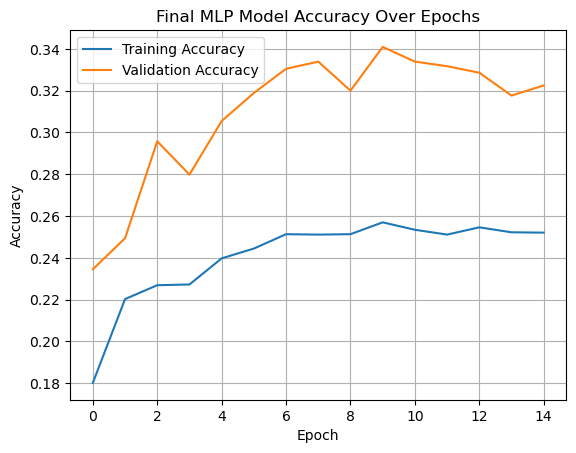

In [382]:
plt.plot(history_best_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_best_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title("Final MLP Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

The above curve shows the final MLP model learning in both training and validation accuracy over epochs. The higher validation accuracy suggests potential underfitting.

### Convolutional neural network

In [377]:
# FINAL CNN MODEL — Convolutional Neural Network (tuned)

# Rebuild the CNN using the best hyperparameters:
# Dropout rate = 0.3,  - Optimizer = 'adam'  ,Batch size = 64 ; Epochs = 10

cnn_final = Sequential()

cnn_final.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
cnn_final.add(MaxPooling2D(pool_size=(2, 2)))
cnn_final.add(Conv2D(64, (3, 3), activation='relu'))
cnn_final.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
cnn_final.add(Flatten())

# Dense layer with 128 neurons and ReLU activation
cnn_final.add(Dense(128, activation='relu'))

# Dropout layer
cnn_final.add(Dropout(0.3))

# Output layer with 9 neurons (one for each class), using softmax for probabilities
cnn_final.add(Dense(9, activation='softmax'))

# Compile the model using 'adam' optimizer and cross-entropy loss
cnn_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()


# Train the CNN on the full training set
history_cnn_final = cnn_final.fit(X_train_cnn, y_train_cat,batch_size=64,  epochs=10,   validation_split=0.2, verbose=1)

end_time = time.time()
print(f"CNN training time: {end_time - start_time:.2f} seconds")


loss_cnn_final, acc_cnn_final = cnn_final.evaluate(X_test_cnn, y_test_cat, verbose=0)

print(f"Final CNN Accuracy: {acc_cnn_final:.4f}")


Epoch 1/10


C:\Users\mridu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2826 - loss: 1.8696 - val_accuracy: 0.5348 - val_loss: 1.2279
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5349 - loss: 1.2312 - val_accuracy: 0.6516 - val_loss: 0.9589
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6175 - loss: 1.0226 - val_accuracy: 0.6903 - val_loss: 0.8639
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6578 - loss: 0.9321 - val_accuracy: 0.7222 - val_loss: 0.7694
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6809 - loss: 0.8643 - val_accuracy: 0.7113 - val_loss: 0.7939
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6875 - loss: 0.8628 - val_accuracy: 0.7136 - val_loss: 0.7718
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7127 - loss: 0.7962 - val_accuracy: 0.7470 - val_loss: 0.7180
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7231 - loss: 0.7649 - val_accuracy: 0.7608 - val_

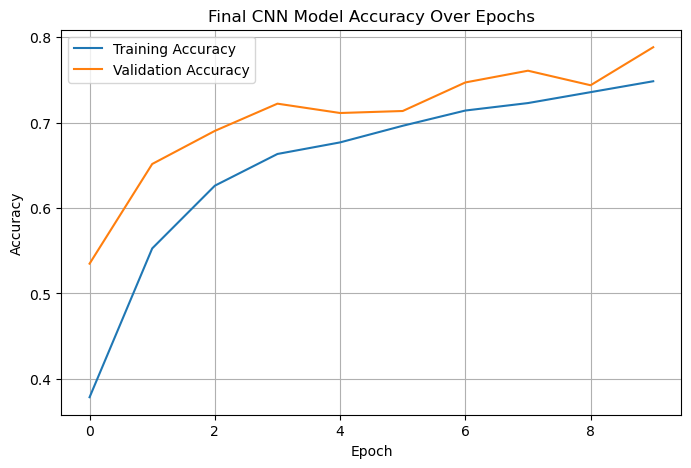

In [379]:
plt.figure(figsize=(8, 5))
plt.plot(history_cnn_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("Final CNN Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


The above plot show the final CNN model’s accuracy improves over 10 epochs on both training and validation data. 